# Análise Descritiva da Prestação de Contas dos Recursos Captados nas Eleições de 2022 no Rio Grande do Sul

## 1. Introdução

Estamos analisando os dados de prestação de contas dos candidatos nas eleições de 2022. Os dados foram coletados da seção de dados abertos do portal gov.br.
O estudo é motivado primeiro pela vontade de aprender sobre ciência de dados, e realizar analises descritivas e prescritivas, além de claro buscar desenvolver a capacidade de extrair insights dos dados analisados sobre como os recursos públicos foram captados no período eleitoral de 2022.

Vamos fazer algumas visualizações descrevendo os dados de algumas variáveis e ao término desse estudo pretende-se responder algumas perguntas:

- Qual o valor total de receitas captado pelos partidos?
- Qual partido mais captou dinheiro no período eleitoral?
- Qual partido menos captou dinheiro no período eleitoral?
- Quais as proporções na captação de recursos para as diferentes fontes de renda?
- Quais as proporções na captação de recursos para os diferentes cargos políticos?
- Existe diferença na distribuição do fundo partidário de acordo com raça?
- Existe diferença na distribuição do fundo partidário de acordo com Gênero?
- Quais as maiores origens de receita?
- Quais as maiores especie de receita?
- Quais os maiores doadores?
- Existem doações sem recibos?
- Existem doações sem documentos?

Após a tentativa de responder essas perguntas, desejamos ver se extraimos insights para aprofundarmos cenários de análise.

Fonte dos Dados: https://dados.gov.br/dados/conjuntos-dados/dadosabertos-tse-jus-br-dataset-prestacao-de-contas-eleitorais-2022

## 2.Carregando Bibliotécas

In [1]:
#importações
import pandas as pd
import numpy as np
from scipy.stats import variation
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import locale
import warnings
from datetime import datetime

#definições
warnings.filterwarnings('ignore')
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

pd.set_option('display.float_format', lambda x: '%.0f' % x)

# plt.style.use('bmh')
slateBlue = '#6A5ACD'
slateBlue1 = '#836FFF'
slateBlue3 = '#6959CD'

#aproveitando esse bloco para definir algumas funções
formatter = FuncFormatter(lambda x, _: '{:,.0f}'.format(x))

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

## 3.Lendo os Dados

In [2]:
#lendo datasets
receitas = pd.read_csv('receitas_candidatos_2022_RS.csv', encoding='latin1', sep=';', parse_dates=['DT_GERACAO','DT_ELEICAO','DT_PRESTACAO_CONTAS','DT_RECEITA'], dayfirst=True, decimal=',', thousands='.')

#algumas tratativas
#diminuindo um pouco a memória usada pelo dataframe transformando colunas com poucos valores no tipo category
cols_categorias = ['TP_PRESTACAO_CONTAS','SG_UF','SG_UE','DS_CARGO','DS_NATUREZA_RECEITA','CD_ESFERA_PARTIDARIA_DOADOR','DS_GENERO','DS_COR_RACA']

for c in cols_categorias:
    receitas[c] = receitas[c].astype('category')

receitas['MES_PREST_CONTAS'] = receitas['DT_PRESTACAO_CONTAS'].apply(lambda x: x.month)

In [3]:
receitas.shape

(22252, 61)

In [4]:
receitas.isnull().sum()

DT_GERACAO                       0
HH_GERACAO                       0
ANO_ELEICAO                      0
CD_TIPO_ELEICAO                  0
NM_TIPO_ELEICAO                  0
                                ..
VR_RECEITA                       0
DS_NATUREZA_RECURSO_ESTIMAVEL    0
DS_GENERO                        0
DS_COR_RACA                      0
MES_PREST_CONTAS                 0
Length: 61, dtype: int64

In [5]:
receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22252 entries, 0 to 22251
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DT_GERACAO                     22252 non-null  datetime64[ns]
 1   HH_GERACAO                     22252 non-null  object        
 2   ANO_ELEICAO                    22252 non-null  int64         
 3   CD_TIPO_ELEICAO                22252 non-null  int64         
 4   NM_TIPO_ELEICAO                22252 non-null  object        
 5   CD_ELEICAO                     22252 non-null  int64         
 6   DS_ELEICAO                     22252 non-null  object        
 7   DT_ELEICAO                     22252 non-null  datetime64[ns]
 8   ST_TURNO                       22252 non-null  int64         
 9   TP_PRESTACAO_CONTAS            22252 non-null  category      
 10  DT_PRESTACAO_CONTAS            22252 non-null  datetime64[ns]
 11  SQ_PRESTADOR_CO

In [6]:
receitas.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,ST_TURNO,TP_PRESTACAO_CONTAS,...,NR_RECIBO_DOACAO,NR_DOCUMENTO_DOACAO,SQ_RECEITA,DT_RECEITA,DS_RECEITA,VR_RECEITA,DS_NATUREZA_RECURSO_ESTIMAVEL,DS_GENERO,DS_COR_RACA,MES_PREST_CONTAS
0,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000002E,#NULO#,28818582,2022-08-16,LAPELAS,278,Publicidade por materiais impressos,Feminino,Branca,10
1,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000006E,#NULO#,28818585,2022-08-17,PRODUÇÃO DE TODOS OS PROGRAMAS DE TV· COMERCIA...,2158,"Produção de programas de rádio, televisão ou v...",Feminino,Branca,10
2,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000004E,47441214000167,28818584,2022-09-14,#NULO#,4600,#NULO#,Feminino,Branca,10
3,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000007E,#NULO#,28818586,2022-08-17,CRIAÇÃO IDENTIDADE VISUAL,1774,"Produção de programas de rádio, televisão ou v...",Feminino,Branca,10
4,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000001E,#NULO#,28818581,2022-08-16,FLYERS,2040,Publicidade por materiais impressos,Feminino,Branca,10


## 4. Totalizadores e Proporções

In [7]:
total_partidos = len(receitas['NM_PARTIDO'].unique())
total_candidatos = len(receitas['NM_CANDIDATO'].unique())
valor_total = receitas['VR_RECEITA'].sum()

In [8]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}Total Candidatos: {total_candidatos}\nTotal Partidos: {total_partidos}\nRecurso Total Captado: {formatar_moeda(valor_total)}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total Candidatos: 1386
Total Partidos: 30
Recurso Total Captado: R$ 308.070.543,07
******************************************************************************



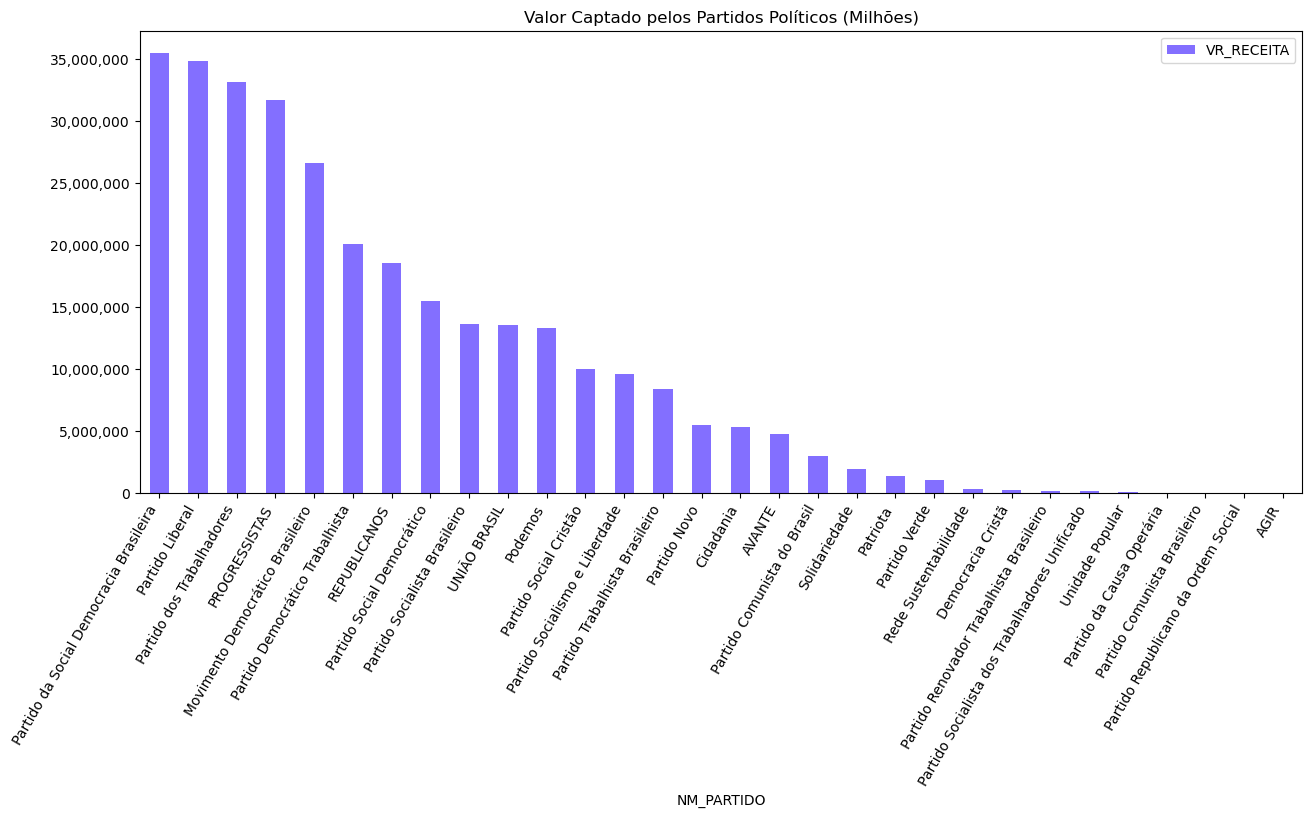

In [9]:
grupo = receitas[['NM_PARTIDO','VR_RECEITA']].groupby('NM_PARTIDO').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(15,6))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
plt.title('Valor Captado pelos Partidos Políticos (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [10]:
display(grupo)

,VR_RECEITA
NM_PARTIDO,
Partido da Social Democracia Brasileira,35533239
Partido Liberal,34881451
Partido dos Trabalhadores,33186278
PROGRESSISTAS,31739582
Movimento Democrático Brasileiro,26626272
Partido Democrático Trabalhista,20095386
REPUBLICANOS,18578683
Partido Social Democrático,15473126
Partido Socialista Brasileiro,13591323


In [11]:
total = len(grupo)
media = grupo['VR_RECEITA'].mean()
std = grupo['VR_RECEITA'].std()
min = grupo['VR_RECEITA'].min()
max = grupo['VR_RECEITA'].max()

In [12]:
grupo.describe()

,VR_RECEITA
count,30
mean,10269018
std,11778765
min,1300
25%,240620
50%,5400410
75%,15002675
max,35533239


In [13]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"

resposta = f"{resposta}Total de Partidos: {total}\n"
resposta = f"{resposta}Menor Valor Captado: {formatar_moeda(min)}\n"
resposta = f"{resposta}Maior Valor Captado: {formatar_moeda(max)}\n"
resposta = f"{resposta}Média Captada por Partido: {formatar_moeda(media)}\n"
resposta = f"{resposta}Desvio Padrão: {std}\n\n"

resposta = f"{resposta}O partido que mais captou recursos foi o {grupo.head(1).index[0]}, \n"
resposta = f"{resposta}Enquanto que o partido que menos captou foi o {grupo.tail(1).index[0]}."
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total de Partidos: 30
Menor Valor Captado: R$ 1.300,00
Maior Valor Captado: R$ 35.533.238,76
Média Captada por Partido: R$ 10.269.018,10
Desvio Padrão: 11778764.582865197

O partido que mais captou recursos foi o Partido da Social Democracia Brasileira, 
Enquanto que o partido que menos captou foi o AGIR.
******************************************************************************



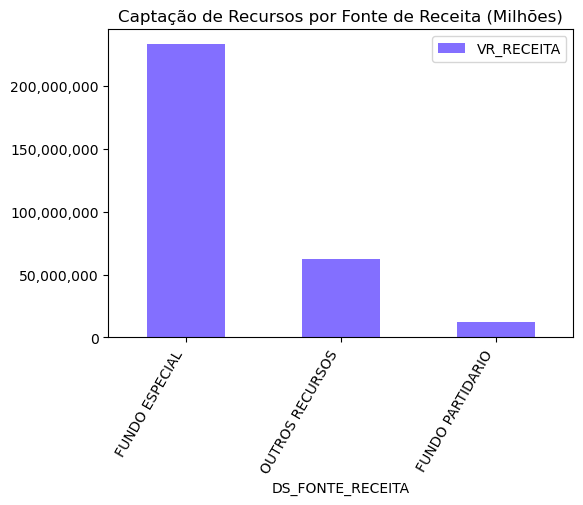

In [14]:
grupo = receitas[['DS_FONTE_RECEITA','VR_RECEITA']].groupby('DS_FONTE_RECEITA').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
_ = plt.title('Captação de Recursos por Fonte de Receita (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [15]:
display(grupo)

,VR_RECEITA
DS_FONTE_RECEITA,
FUNDO ESPECIAL,233322772
OUTROS RECURSOS,62729792
FUNDO PARTIDARIO,12017979


In [16]:
total = len(grupo)
media = grupo['VR_RECEITA'].mean()
std = grupo['VR_RECEITA'].std()
min = grupo['VR_RECEITA'].min()
max = grupo['VR_RECEITA'].max()

In [17]:
grupo.describe()

,VR_RECEITA
count,3
mean,102690181
std,115937817
min,12017979
25%,37373885
50%,62729792
75%,148026282
max,233322772


In [18]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"

resposta = f"{resposta}Fontes de Receita: {total}\n"
resposta = f"{resposta}Menor Valor Captado: {formatar_moeda(min)}\n"
resposta = f"{resposta}Maior Valor Captado: {formatar_moeda(max)}\n"
resposta = f"{resposta}Média Captada por Fonte de Receita: {formatar_moeda(media)}\n"
resposta = f"{resposta}Desvio Padrão: {std}\n\n"

resposta = f"{resposta}A maior fonte receita foi de {grupo.head(1).index[0]}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Fontes de Receita: 3
Menor Valor Captado: R$ 12.017.979,08
Maior Valor Captado: R$ 233.322.772,44
Média Captada por Fonte de Receita: R$ 102.690.181,02
Desvio Padrão: 115937817.10974829

A maior fonte receita foi de FUNDO ESPECIAL
******************************************************************************



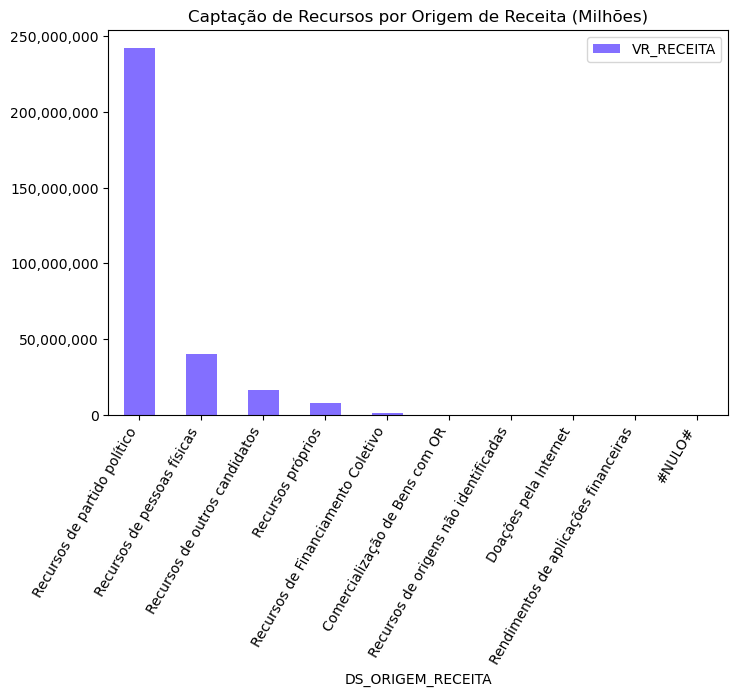

In [19]:
grupo = receitas[['DS_ORIGEM_RECEITA','VR_RECEITA']].groupby('DS_ORIGEM_RECEITA').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
_ = plt.title('Captação de Recursos por Origem de Receita (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [20]:
display(grupo)

,VR_RECEITA
DS_ORIGEM_RECEITA,
Recursos de partido político,242198842
Recursos de pessoas físicas,40210346
Recursos de outros candidatos,16555676
Recursos próprios,8113988
Recursos de Financiamento Coletivo,961275
Comercialização de Bens com OR,16920
Recursos de origens não identificadas,8288
Doações pela Internet,4306
Rendimentos de aplicações financeiras,902


In [21]:
total = len(grupo)
media = grupo['VR_RECEITA'].mean()
std = grupo['VR_RECEITA'].std()
min = grupo['VR_RECEITA'].min()
max = grupo['VR_RECEITA'].max()

In [22]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"

resposta = f"{resposta}Origens de Receita: {total}\n"
resposta = f"{resposta}Menor Valor Captado: {formatar_moeda(min)}\n"
resposta = f"{resposta}Maior Valor Captado: {formatar_moeda(max)}\n"
resposta = f"{resposta}Média Captada por Origem de Receita: {formatar_moeda(media)}\n"
resposta = f"{resposta}Desvio Padrão: {std}\n\n"

resposta = f"{resposta}As maiores origens de receitas são:\n\n"
resposta = f"{resposta}1 - {grupo.index[0]}\n"
resposta = f"{resposta}2 - {grupo.index[1]}\n"
resposta = f"{resposta}3 - {grupo.index[2]}\n"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Origens de Receita: 10
Menor Valor Captado: R$ 0,00
Maior Valor Captado: R$ 242.198.842,07
Média Captada por Origem de Receita: R$ 30.807.054,31
Desvio Padrão: 75371123.79277802

As maiores origens de receitas são:

1 - Recursos de partido político
2 - Recursos de pessoas físicas
3 - Recursos de outros candidatos

******************************************************************************



In [23]:
grupo = receitas[['NM_DOADOR','VR_RECEITA']].groupby('NM_DOADOR').sum().sort_values(by='VR_RECEITA', ascending=False)
grupo.head()

,VR_RECEITA
NM_DOADOR,
Direção Nacional,128858117
Direção Estadual/Distrital,62375232
DIREÇÃO NACIONAL,43112607
DIREÇÃO ESTADUAL/DISTRITAL,7047647
HEITOR V LINDEN,2600000


In [24]:
desc = grupo.describe()
desc

,VR_RECEITA
count,9039
mean,34082
std,1574708
min,0
25%,300
50%,1000
75%,4000
max,128858117


In [25]:
total = len(grupo)
media = grupo['VR_RECEITA'].mean()
std = grupo['VR_RECEITA'].std()
min = grupo['VR_RECEITA'].min()
max = grupo['VR_RECEITA'].max()

In [26]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"

resposta = f"{resposta}Doadores: {total}\n"
resposta = f"{resposta}Menor Valor Doado: {formatar_moeda(min)}\n"
resposta = f"{resposta}Maior Valor Doado: {formatar_moeda(max)}\n"
resposta = f"{resposta}Média de Valores Doados: {formatar_moeda(media)}\n"
resposta = f"{resposta}Desvio Padrão: {std}\n\n"

resposta = f"{resposta}Os 3 maiores doadores são:\n\n"
resposta = f"{resposta}1 - {grupo.index[0]}\n"
resposta = f"{resposta}2 - {grupo.index[1]}\n"
resposta = f"{resposta}3 - {grupo.index[2]}\n"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Doadores: 9039
Menor Valor Doado: R$ 0,02
Maior Valor Doado: R$ 128.858.117,10
Média de Valores Doados: R$ 34.082,37
Desvio Padrão: 1574708.115539535

Os 3 maiores doadores são:

1 - Direção Nacional
2 - Direção Estadual/Distrital
3 - DIREÇÃO NACIONAL

******************************************************************************



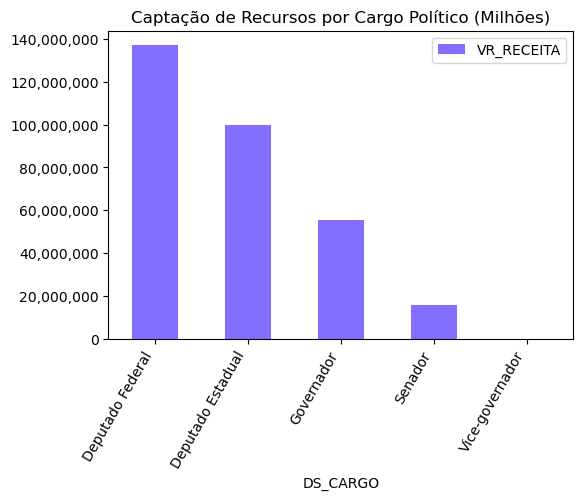

In [27]:
grupo = receitas[['DS_CARGO','VR_RECEITA']].groupby('DS_CARGO', observed=False).sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
_ = plt.title('Captação de Recursos por Cargo Político (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [28]:
display(grupo)

,VR_RECEITA
DS_CARGO,
Deputado Federal,137064861
Deputado Estadual,99909465
Governador,55246961
Senador,15849256
Vice-governador,0


In [29]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}Os valores captados por cargo político são:\n\n"
for i,v in grupo.iterrows():
    resposta = F"{resposta}Cargo: {i} - Valor Captado: {formatar_moeda(v['VR_RECEITA'])}\n"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)    

******************************************************************************
[RESPOSTA]:

Os valores captados por cargo político são:

Cargo: Deputado Federal - Valor Captado: R$ 137.064.860,54
Cargo: Deputado Estadual - Valor Captado: R$ 99.909.465,35
Cargo: Governador - Valor Captado: R$ 55.246.961,00
Cargo: Senador - Valor Captado: R$ 15.849.256,18
Cargo: Vice-governador - Valor Captado: R$ 0,00

******************************************************************************



## 5. Algumas Frequências e Proporções

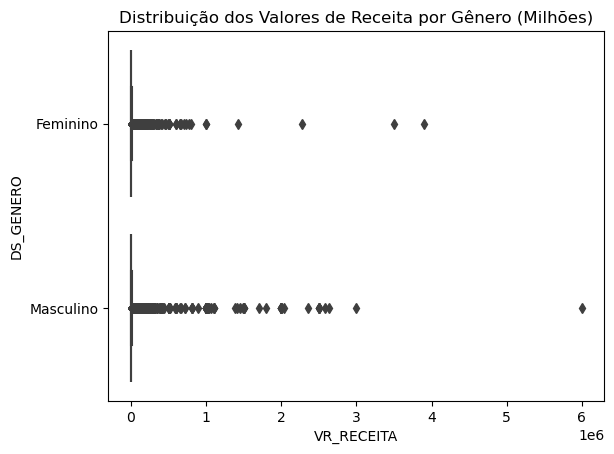

In [30]:
plt.title('Distribuição dos Valores de Receita por Gênero (Milhões)')
_ = sns.boxplot(y='DS_GENERO', x='VR_RECEITA', data=receitas)

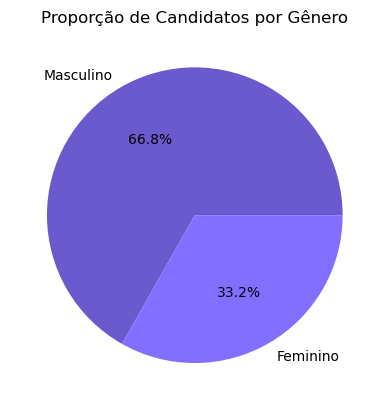

In [31]:
filtro_rec_masc = receitas[ receitas['DS_GENERO'] == 'Masculino' ]
filtro_rec_fem = receitas[ receitas['DS_GENERO'] == 'Feminino' ]
qtde_masc = len( filtro_rec_masc['NM_CANDIDATO'].unique() )
qtde_fem = len( filtro_rec_fem['NM_CANDIDATO'].unique() )

_ = plt.title('Proporção de Candidatos por Gênero')
_ = plt.pie([qtde_masc, qtde_fem],labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

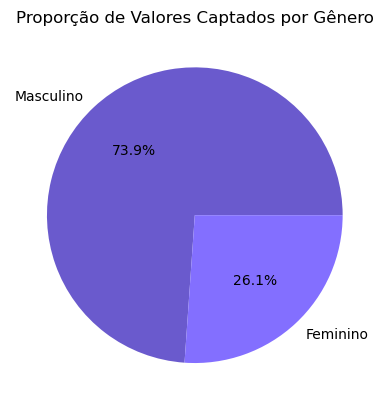

In [32]:
receitas_masc = filtro_rec_masc['VR_RECEITA'].sum()
receitas_fem = filtro_rec_fem['VR_RECEITA'].sum()

_ = plt.title('Proporção de Valores Captados por Gênero')
_ = plt.pie([receitas_masc, receitas_fem], labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

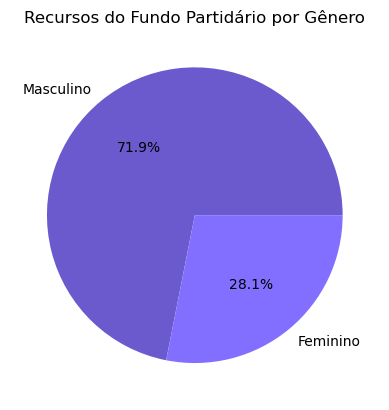

In [33]:
recurso_masc_fundopart = filtro_rec_masc[ filtro_rec_masc['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO']['VR_RECEITA'].sum()
recurso_fem_fundopart = filtro_rec_fem[ filtro_rec_fem['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO' ]['VR_RECEITA'].sum()

_ = plt.title('Recursos do Fundo Partidário por Gênero')
_ = plt.pie([recurso_masc_fundopart, recurso_fem_fundopart], labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

In [34]:
media_por_masc = recurso_masc_fundopart / qtde_masc
media_por_fem = recurso_fem_fundopart / qtde_fem

genero_maior = 'Feminino'

if media_por_masc > media_por_fem:
    genero_maior = 'Masculino'

igualdade_generos = ' NÃO HOUVE IGUALDADE '
desc_maior_genero = f", já que o Gênero {genero_maior} foi o que mais recebeu receitas do Fundo Partidário."
flag_ig_generos = False

if media_por_masc == media_por_fem:
    igualdade_generos = ' HOUVE IGUALDADE '
    desc_maior_genero = '.'
    flag_ig_generos = True

In [35]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}A média distribuída a pelo Fundo Partidario aos candidatos de Gênero Masculino foi de {formatar_moeda(media_por_masc)}. \n"
resposta = f"{resposta}Por outro lado a média para o Gênero Feminino foi de {formatar_moeda(media_por_fem)}.\n\n"
resposta = f"{resposta}Considerando essas médias,{igualdade_generos}nos valores distribuídos pelo Fundo Partidário de acordo com Gênero"
resposta = f"{resposta}{desc_maior_genero}."
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

A média distribuída a pelo Fundo Partidario aos candidatos de Gênero Masculino foi de R$ 9.330,88. 
Por outro lado a média para o Gênero Feminino foi de R$ 7.342,57.

Considerando essas médias, NÃO HOUVE IGUALDADE nos valores distribuídos pelo Fundo Partidário de acordo com Gênero, já que o Gênero Masculino foi o que mais recebeu receitas do Fundo Partidário..
******************************************************************************



In [36]:
fund_part = receitas[ receitas['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO' ]
dados_plot = fund_part[['DS_COR_RACA','VR_RECEITA']].groupby('DS_COR_RACA').sum().sort_values(by='VR_RECEITA', ascending=False)

info_raca = []

for r in fund_part['DS_COR_RACA'].unique():
    regs_r = fund_part[ fund_part['DS_COR_RACA'] == r ]
    valor = regs_r['VR_RECEITA'].sum()
    candidatos = len( regs_r['NM_CANDIDATO'].unique() )
    media = valor / candidatos

    info_raca.append({
        'raca':r,
        'valor':valor,
        'media':media,
        'candidatos':candidatos
    })

grupo = pd.DataFrame(info_raca)

display(grupo)

,raca,valor,media,candidatos
0,Branca,10385766,59347,175
1,Parda,650266,40642,16
2,Preta,578036,34002,17
3,Indígena,403912,201956,2


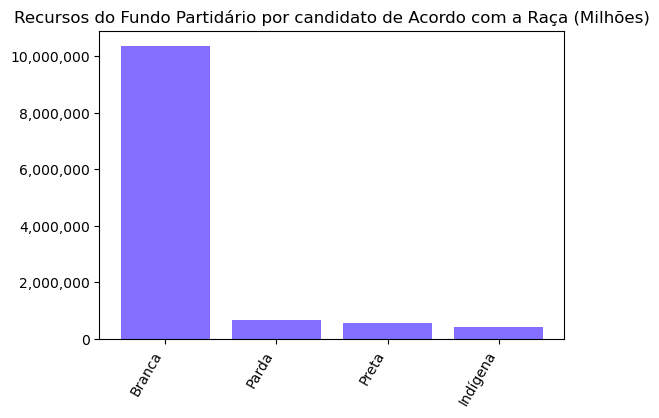

In [37]:
fig, ax = plt.subplots(figsize=(6,4))
_ = plt.bar(grupo['raca'], grupo['valor'], color=slateBlue1)
_ = plt.title('Recursos do Fundo Partidário por candidato de Acordo com a Raça (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

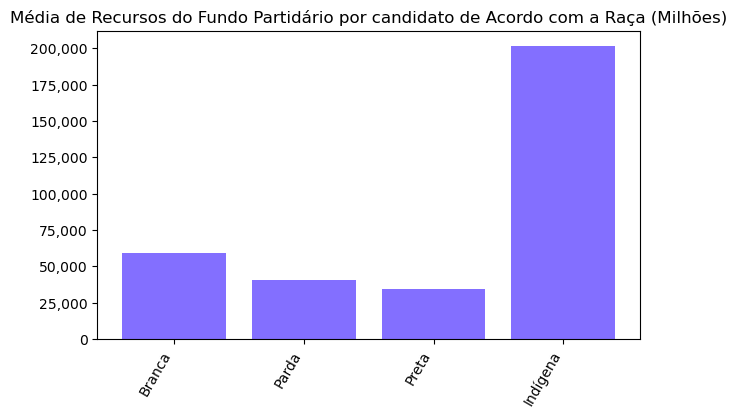

In [38]:
fig, ax = plt.subplots(figsize=(7,4))
_ = plt.bar(grupo['raca'], grupo['media'], color=slateBlue1)
_ = plt.title('Média de Recursos do Fundo Partidário por candidato de Acordo com a Raça (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [39]:
medias = grupo['media'].tolist()
cv = variation(medias, axis=0)

In [40]:
msg_resposta = 'Não houve grandes variações'

if cv >= 0.5:
    msg_resposta = 'Houve grandes variações'
    
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}O coeficiente de variação nas médias por candidato recebidas pelo Fundo Partidário foi de {cv},\n"
resposta = f"{resposta}indicando que {msg_resposta}.\n"
resposta = f"{resposta}Importante destacar que não adianta calcular o CV em cima dos valores recebidos por raça, \n"
resposta = f"{resposta}isso porque a quantidade de candidatos por raça parece estar impactando diretamente no valor total de receitas, \n"
resposta = f"{resposta}por isso, verificar o CV em cima das médias de distribuição do próprio fundo partidário de acordo com raça parece mais sensato."
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

O coeficiente de variação nas médias por candidato recebidas pelo Fundo Partidário foi de 0.8184705080962674,
indicando que Houve grandes variações.
Importante destacar que não adianta calcular o CV em cima dos valores recebidos por raça, 
isso porque a quantidade de candidatos por raça parece estar impactando diretamente no valor total de receitas, 
por isso, verificar o CV em cima das médias de distribuição do próprio fundo partidário de acordo com raça parece mais sensato.
******************************************************************************



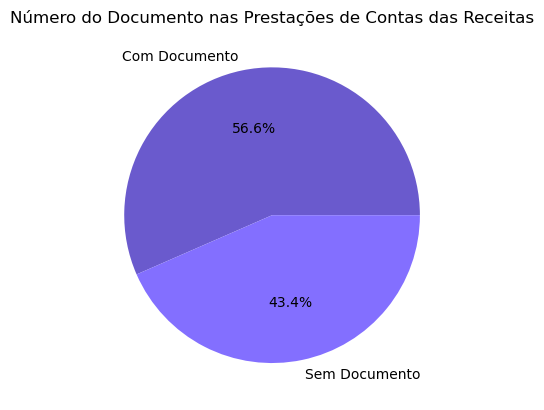

In [41]:
total_sem_doc = len(receitas[ receitas['NR_DOCUMENTO_DOACAO'].apply(lambda x: 'NUL' in  x) ])
total_com_doc = len(receitas[ receitas['NR_DOCUMENTO_DOACAO'].apply(lambda x: 'NUL' not in x) ])

_ = plt.pie([total_com_doc, total_sem_doc], labels=['Com Documento','Sem Documento'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])
_ = plt.title('Número do Documento nas Prestações de Contas das Receitas')

In [42]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}Total de Registros de Prestação de Contas de Receitas: {len(receitas)}\n"
resposta = f"{resposta}Registros COM Número de Documento Informados: {total_com_doc}\n"
resposta = f"{resposta}Registros SEM Número de Documento Informados: {total_sem_doc}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total de Registros de Prestação de Contas de Receitas: 22252
Registros COM Número de Documento Informados: 12585
Registros SEM Número de Documento Informados: 9667
******************************************************************************



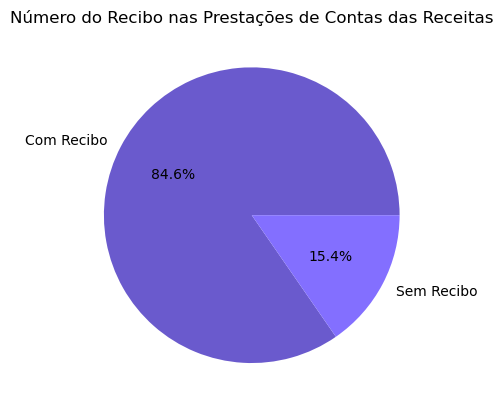

In [43]:
total_sem_rec = len(receitas[ receitas['NR_RECIBO_DOACAO'].apply(lambda x: 'NUL' in  x) ])
total_com_rec = len(receitas[ receitas['NR_RECIBO_DOACAO'].apply(lambda x: 'NUL' not in x) ])

_ = plt.pie([total_com_rec, total_sem_rec], labels=['Com Recibo','Sem Recibo'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])
_ = plt.title('Número do Recibo nas Prestações de Contas das Receitas')

In [44]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}Total de Registros de Prestação de Contas de Receitas: {len(receitas)}\n"
resposta = f"{resposta}Registros COM Número de Recibo Informados: {total_com_rec}\n"
resposta = f"{resposta}Registros SEM Número de Recibo Informados: {total_sem_rec}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total de Registros de Prestação de Contas de Receitas: 22252
Registros COM Número de Recibo Informados: 18833
Registros SEM Número de Recibo Informados: 3419
******************************************************************************



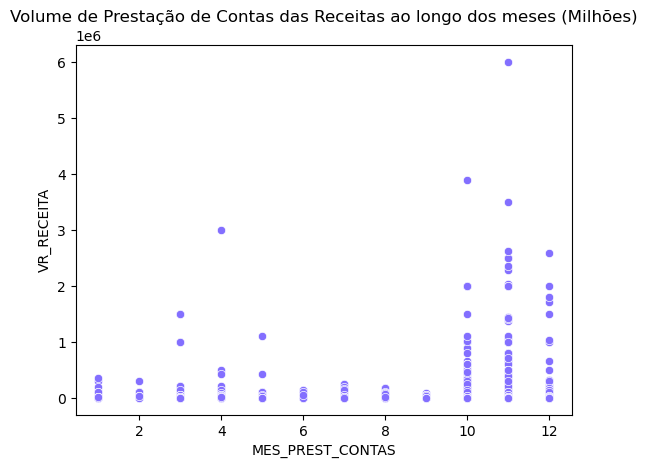

In [45]:
plt.title('Volume de Prestação de Contas das Receitas ao longo dos meses (Milhões)')
_ = sns.scatterplot(y='VR_RECEITA', x='MES_PREST_CONTAS', data=receitas, color=slateBlue1)

In [46]:
grupo = receitas[['MES_PREST_CONTAS','VR_RECEITA']].groupby('MES_PREST_CONTAS').sum().sort_values(by='VR_RECEITA', ascending=False)
grupo.describe()

,VR_RECEITA
count,12
mean,25672545
std,49945454
min,1010187
25%,2877759
50%,4173139
75%,14035023
max,169213453


In [47]:
total = len(grupo)
media = grupo['VR_RECEITA'].mean()
std = grupo['VR_RECEITA'].std()
min = grupo['VR_RECEITA'].min()
max = grupo['VR_RECEITA'].max()

In [48]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"

resposta = f"{resposta}Total Meses onde houve prestação de contas: {total}\n"
resposta = f"{resposta}Menor Volume de Prestação de contas em um mês: {formatar_moeda(min)}\n"
resposta = f"{resposta}Maior Volume de Prestação de contas em um mês: {formatar_moeda(max)}\n"
resposta = f"{resposta}Média Mensal: {formatar_moeda(media)}\n"
resposta = f"{resposta}Desvio Padrão: {std}\n\n"

resposta = f"{resposta}Os 3 maiores meses com maiores volumes de contas prestadas são:\n\n"
resposta = f"{resposta}1 - {grupo.index[0]}\n"
resposta = f"{resposta}2 - {grupo.index[1]}\n"
resposta = f"{resposta}3 - {grupo.index[2]}\n"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total Meses onde houve prestação de contas: 12
Menor Volume de Prestação de contas em um mês: R$ 1.010.187,37
Maior Volume de Prestação de contas em um mês: R$ 169.213.452,74
Média Mensal: R$ 25.672.545,26
Desvio Padrão: 49945453.93177521

Os 3 maiores meses com maiores volumes de contas prestadas são:

1 - 11
2 - 10
3 - 12

******************************************************************************



## 6. Conclusão

### 6.1 - Descrição

Houve um total de 22252 (22 mil) registros de prestação de contas, realizados ao longo do ano de 2022. 
A média mensal de prestação de contas das receitas captadas foi de mais de 25 milhões de reais mensais, os meses 
com maior volume de prestação de contas foram Outubro, Novembro e Dezembro.

Ao todo foram **1386 candidatos em 30 partidos, tendo captado um total de mais de 300 milhões** de reais. 

Os **partidos que mais captaram** dinheiro foram: <br>

- Partido da Social Democracia Brasileira (mais de 35 milhões)
- Partido Liberal (aproximadamente 35 milhões)
- Partido dos Trabalhadores (mais de 33 milhões)
- E Progressistas (aproximadamente 32 milhões)

Dos 300 milhões captados por 30 partidos, esses 4 partidos sozinhos captaram mais de 130 milhões: <br>

Três foram as **fontes de receita**: <br>

- FUNDO ESPECIAL mais de 230 milhões
- OUTROS RECURSOS mais de 62 milhões
- FUNDO PARTIDÁRIO mais de 12 milhões

Sobre as **origens das receitas** as 4 maiores foram: <br>

- Recursos de partido político (mais de 242 milhões)
- Recursos de pessoas físicas (mais de 40 milhões)
- Recursos de outros políticos (mais de 16 milhões)
- Recursos próprios (mais de 8 milhões)

Dos **cargos políticos**: <br>

- Deputados Federais captaram pouco mais 137 milhões
- Deputados Estaduais aproximadamente 100 milhões
- Governador mais de 55 milhões
- E Senadores aproximadamente 16 milhões.

Sobre a **distribuição de recursos pelo fundo partidário de acordo com gênero**, candidatos do gênero masculino receberam em média 9.330,88, enquanto que do gênero feminino 7.342,57. Foi observado que a frequencia média para o gênero masculino foi maior que a do gênero feminino, por outro lado 66,8% dos candidatos são do gênero masculino, enquanto que apenas 33,2% são mulheres. 

Nesse ponto os dados mostram que o **Fundo Partidário não distribuiu os mesmos valores de acordo com gênero**, de forma que os candidatos de gênero masculino receberam mais.

De **acordo com a raça, o Fundo Partidário distribuiu** recursos para 210 candidatos, sendo das raças, 175 branca, 16 parda, 17 preta e 2 indígenas

Nesse ponto os dados mostram o a **raça preta teve a menor média** de recursos por candidato, recebeu aproximadamente 34 mil em média por candidato. 
A raça parda recebeu em média, 40 mil por candidato, os brancos receberam 59 mil por candidato em média. Os **indígenas são destaque, em média receberam mais de 200 mil por candidato**.

Sobre os registros de prestação de contas, **56,6% dos registros possuem um número de documento na prestação** de contas, enquanto que **43,4% não possuem**.
Da mesma maneira, **sobre o recibo na prestação de contas, 84,5% possuem recibo e 15,4% não possuem**.

### 6.2 - Pontos Interessantes

Não é possível com esses dados obter insights mais valiosos sobre algumas categorias observadas, tais como partidos, fontes de receita, origens de receita, cargos políticos, já que seria necessária uma melhor segmentação dos dados em cada categoria, para aprofundar a descrição dos padrões de dados.

No entanto existe uma questão interessante. Se considerar os 12 milhões recebidos do fundo partidário, e em contra partida os mais de 242 milhões originados de "Recursos de partido político" no mínimo duas perguntas são necessárias: 

- Se 242 milhões foram originados de "Recursos de partido político" qual a necessidade dos 12 milhões do Fundo Partidario? Já que em tese os partidos políticos parecem ter bastante recursos.
- Esses 242 milhões de recursos de partidos políticos tem alguma relação com os 233 milhões recebidos de "FUNDO ESPECIAL" na categoria Fonte de Receita?

Talvez seja interessante aprofundar mais sobre as regras negociais em torno disso e explorar um pouco mais essas categorias.

Outra questão importante, sobre distribuição de recursos por gênero:<br>

- Não houve distribuição de recursos igualitária de acordo com gênero.

Seja como for a logística para que o recurso chegue nas mãos dos candidatos, seja diretamente pelo fundo partidário, ou intermediado pelos partidos políticos, o fato é que não houve distribuição igualitária para candidatos de acordo com gênero, de forma que os homens receberam mais recursos que as mulheres. Aqui, seria interessante identificar mais categorias dentre os dados disponíveis e segmentar essa abordagem, afim de descobrir as tendências por partido, cargo político, etc. Por exemplo uma pergunta interessante seria, **Em qual partido houve mais desigualdade?**

Outro aspecto diz respeito a distribuição de recuros do Fundo Partidário de acordo com raça. 

- Por que os indígenas receberam mais de 200 mil em média por candidato?
- Por a distribuição por raça não foi igualitária?

A raça não deve e nem deveria pautar um estudo, porém os dados mostram que indígenas tiveram um grande destaque no repasse dos recursos de fundo partidário em média em relação às outras raças. Entre brancos, pardos e pretos houve uma diferença também, mas não foi tão grande quanto a dos indígenas, e porque essas diferenças?

Essas questões sobre recursos do fundo partidário que foram repassados de maneira desigual, devem ser vistos sobre duas óticas:

- Se o recurso é passado diretamente para as mãos dos candidatos, então o governo foi desigual?
- Por outro lado, se o recurso é passado aos partidos políticos e estes fazem o repasse aos candidatos, então os partidos foram desiguais?

Quem foi desigual, o governo ou os partidos? 
Quais as regras na distribuição de recursos?

Notemos que são questionamentos que provavelmente não sejam passíveis de respostas apenas com os dados, mas os dados apontam para esses questionamentos. No máximo podemos segmentar um pouco mais em uma nova exploração, e descobrir qual partido ou qual cargo político por exemplo isso mais ocorreu, mas ainda existem regras e fatores externos que complementariam as respostas dos questionamentos aqui orientados.

Por fim, outro ponto interssante é,

- Por que a maior parte da prestação de contas só ocorreu nos 3 últimos meses do ano?

Essa é mais uma questão que assim como as anteriores, se olharmos para os dados que temos, podemos aprofundar um pouco mais em termos de exploração, para conhecer os padrões, mas a resposta completa dependeria de mais fatores externos além dos dados, no entanto mais uma questão válida para reflexão.
